In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf

from quask.core import Ansatz, Kernel, KernelFactory, KernelType
# from quask.core_implementation.pennylane_kernel import PennylaneKernel
from quask.evaluator import HaarEvaluator, LieRankEvaluator

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

import matplotlib.pyplot as plt
import matplotlib as mpl

# Importance of Kernel Bandwidth in QML

## Fashion-MNIST Dataset

The Fashion-MNIST dataset is an image classification for distinguishing clothing items. We follow the preprocessing of the input data as done in [The power of data in Quantum Machine Learning](https://arxiv.org/abs/2011.01938). We use Principal Component Analysis (PCA) to reduce each image to an $n$-dimensional vector, the so-called **feature** vector.

Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12000
Number of filtered test examples: 2000
True


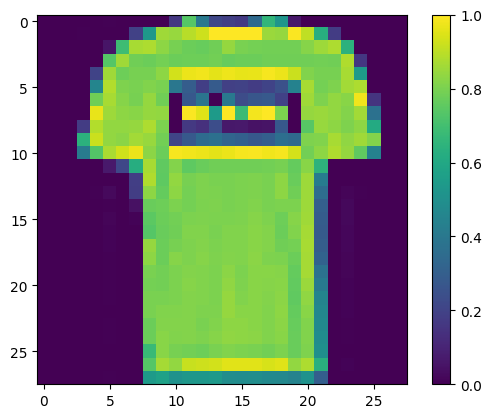

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

In [3]:
# =============================================================================
# Create dataset
# =============================================================================  
def create_dataset(N_TRAIN: int, features_DIM: int, n_test: float=0.2):
    """
    create dataset

    This function loads data from the fashion_mnist and manipulates
    data to suit our problem, e.g. normalization and feature selection.

    N_TRAIN: int - number of training data to train our ML model
    features_DIM: int - number of features will have each datum. It corresponds to
                  the number of qubits if the encoding is one to one.
    n_test: float - percentage of datapoints we need for the test.
    """
    # load data
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # convert to float in order to normalize the values of the features
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # normalization of the features from [0,255] to [0,1]
    X_train /= 255
    X_test /= 255
    
    # select only two classes to have a binary classification problem
    # =============================================================================
    # filter 0-3
    # =============================================================================
    def filter_03(x, y):
        """
        filter 0-3

        This function keeps only the dresses and t-shorts of the
        fashion mnist dataset in order to have only a binary classification problem

        x: datapoint vector
        y: target/label vector relative to the x vector

        """
        keep = (y == 0) | (y == 3)
        x, y = x[keep], y[keep]
        y = y == 0
        return x,y
    
    # apply the filter 
    X_train, y_train = filter_03(X_train, y_train)
    X_test, y_test = filter_03(X_test, y_test)
    # =============================================================================
    # Truncate x
    # =============================================================================
    def truncate_x(X_train, X_test, n_components=features_DIM):
        """
        truncate x

        Perform PCA on image dataset keeping the top `n_components` components.
        
        X_train: training dataset
        X_test: test dataset
        n_components: number of features we want to keep after PCA

        """
        n_points_train = tf.gather(tf.shape(X_train), 0)
        n_points_test = tf.gather(tf.shape(X_test), 0)

        # Flatten to 1D
        X_train = tf.reshape(X_train, [n_points_train, -1])
        X_test = tf.reshape(X_test, [n_points_test, -1])

        # Normalize.
        feature_mean = tf.reduce_mean(X_train, axis=0)
        X_train_normalized = X_train - feature_mean
        X_test_normalized = X_test - feature_mean

        # Truncate.
        e_values, e_vectors = tf.linalg.eigh(
          tf.einsum('ji,jk->ik', X_train_normalized, X_train_normalized))
        return tf.einsum('ij,jk->ik', X_train_normalized, e_vectors[:,-n_components:]), \
          tf.einsum('ij,jk->ik', X_test_normalized, e_vectors[:, -n_components:])

    # truncating datasets
    X_train, X_test = truncate_x(X_train, X_test, n_components=features_DIM)
    
    print(f'New datapoint dimension:', len(X_train[0]))    

    # restrict the dataset to a smaller ensemble
    N_TEST = round(N_TRAIN*n_test)
    X_train, X_test = X_train[:N_TRAIN], X_test[:N_TEST]
    y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

    print('Number of datapoints', len(X_train))
    
    X_train = np.reshape(X_train, (len(X_train), features_DIM))
    X_test = np.reshape(X_test, (len(X_test), features_DIM))

    print('Data loaded.')
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=800, features_DIM=5)
X_test.shape

New datapoint dimension: 5
Number of datapoints 800
Data loaded.


(160, 5)

## The Quantum Feature Map

Actually, the number of features for one image (thus, one circuit embedding) could be bigger than the number of qubits $d$ according to the feature map we pick. In this case we again refer to a well known feature map called Instantaneous Quantum Polynomial (IQP) feature map. 

$$|\textbf{x}_i\rangle = U_{Z}(\textbf{x}_i) H^{\otimes d} U_{Z}(\textbf{x}_i) H^{\otimes d}|0^d\rangle$$

where

$$ U_{Z}(\textbf{x}_i) = \text{exp} \left( \sum_{j=1}^d \lambda x_{ij}Z_j + \sum_{j=1}^d \sum_{j'=1}^d \lambda^2 x_{ij} x_{ij'} Z_j Z_{j'} \right) \quad . $$

Then, our feature array contains both the single-qubit and two-qubit features (the product of the single-qubit features pair entangled by the map scheme).

$$ \textbf{x}_i = (x_{i1}\;, x_{i2}\;, ..., x_{id}\;, \lambda x_{i1}x_{i2}\;, \lambda x_{i1}x_{i3}\;, ..., \lambda x_{id-1}x_{id}\;) .$$

The number of additional features depends on the type of entanglement we choose. A full entanglement brings to an additional number of features equal to $\binom{d}{2}$. Finally, the total number of features for a single datapoint (as in, image) equals to $d + \binom{d}{2}$.

In [9]:
def create_pennylane_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return PennylaneKernel(ansatz, measurement, type, device_name="lightning.qubit", n_shots=None)

KernelFactory.add_implementation('pennylane_noiseless_lightning', create_pennylane_noiseless)
KernelFactory.set_current_implementation('pennylane_noiseless_lightning')
print(KernelFactory._KernelFactory__implementations)
print(KernelFactory._KernelFactory__current_implementation)

{'pennylane_noiseless_lightning': <function create_pennylane_noiseless at 0x000001640D540EA0>}
pennylane_noiseless_lightning


In [111]:
# =============================================================================
# IQP Kernel
# =============================================================================
def UZCircuit(ansatz, bandwidth, count=0):
    d = ansatz.n_qubits
    # Z term - local
    for k in range(d):
        ansatz.change_operation(count, new_feature=k, new_wires=[k, (k+1)%d], new_generator="ZI", new_bandwidth=bandwidth)
        count += 1

    # ZZ term - full entanglement 
    for i in range(d-1):
        for j in range(i+1, d):
            ansatz.change_operation(count, new_feature=k+i, new_wires=[i, j], new_generator="ZZ", new_bandwidth=bandwidth)
            count += 1

    return ansatz, count

def HCircuit(ansatz, bandwidth=1, count=0):
    d = ansatz.n_qubits
    n_features = d + d*(d-1)/2 + 1 # we have the last feature fixed to one for non-parametrizable gates
    for i in range(d):
        ansatz.change_operation(count, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="XI", new_bandwidth=np.pi/2) # R_x(pi/2)
        ansatz.change_operation(count+1, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="ZI", new_bandwidth=np.pi/2) # R_z(pi/2)
        ansatz.change_operation(count+2, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="XI", new_bandwidth=np.pi/2) # R_x(pi/2)
        ansatz.change_operation(count+3, new_feature=n_features, new_wires=[i, (i+1)%d], new_generator="II", new_bandwidth=np.pi)   # e^(i pi/2)

    count = count + 3
    return ansatz, count

def IQPCircuit(ansatz, bandwidth):
    # first U_Z(x_i)
    ansatz_uz1, count_uz1 = UZCircuit(ansatz, bandwidth)
    # first layer of hadamard gates
    ansatz_uz1h1, count_uz1h1 = HCircuit(ansatz_uz1, bandwidth, count=count_uz1)
    # second U_Z(x_i)
    ansatz_uz1h1uz2, count_uz1h1uz2 = UZCircuit(ansatz_uz1h1, bandwidth, count=count_uz1h1)
    # second layer of hadamard gates
    ansatz_uz1h1uz2h2, _ = HCircuit(ansatz_uz1h1uz2, bandwidth, count=count_uz1h1uz2)
    return ansatz_uz1h1uz2h2

# we can define a new function to construct the Ansatz since we will loop for different bandwidth values
def VaryingBandwidthQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # we choose a IQPCircuit
    circuit = IQPCircuit(ansatz, bandwidth)
    # kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.FIDELITY)
    kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel

# =============================================================================
# Ising-like Kernel
# =============================================================================
# help funciton to select on which qubit we want to perform our measurement
def measurement_qubit(N_QUBITS, measurement):
    pauli_string = ""
    for i in range(N_QUBITS):
        if i < measurement:
            pauli_string = pauli_string + "I"
        if i == measurement:
            pauli_string = pauli_string + "Z"
        if i > measurement:
            pauli_string = pauli_string + "I"
    return pauli_string

# let us define the Ansatz which implements this
def IsingCircuit(ansatz, bandwidth):
    d = ansatz.n_qubits
    # linear CZ entanglement
    for j in range(d-1):
        ansatz.change_operation(j, new_feature=d+j, new_wires=[j, j+1], new_generator="ZZ", new_bandwidth=bandwidth)

    # single qubit rotations in x: RX wall
    for i in range(d):
        j += 1
        ansatz.change_operation(j, new_feature=i, new_wires=[i, (i+1)%d], new_generator="XI", new_bandwidth=bandwidth)
    return ansatz

def ManyBodyQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth, measurement=None):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # we choose a IQPCircuit
    circuit = IsingCircuit(ansatz, bandwidth)
    # kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.FIDELITY)
    # kernel = KernelFactory.create_kernel(circuit, measurement_qubit(N_QUBITS=N_QUBITS, measurement=measurement), KernelType.OBSERVABLE)
    kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel


# =============================================================================
# Linear (single-qubit gates) Kernel
# =============================================================================
def LinearCircuit(ansatz, bandwidth):
    d = ansatz.n_qubits
    # single qubit rotations in x: RX wall
    for i in range(d):
        ansatz.change_operation(i, new_feature=i, new_wires=[i, (i+1)%d], new_generator="IX", new_bandwidth=bandwidth)
    return ansatz

def LinearQuantumKernel(N_FEATURES, N_QUBITS, N_OPERATIONS, bandwidth, platform="finite_shots", n_shots=None):
    ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
    ansatz.initialize_to_identity()
    # choose linear circuit
    circuit = LinearCircuit(ansatz, bandwidth)

    kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.FIDELITY)
    # kernel = KernelFactory.create_kernel(circuit, "Z" * N_QUBITS, KernelType.OBSERVABLE)
    return kernel

## Embedding the datapoints

The number of operations we have to perform following the `IPQCircuit` map are:

$$ \underbrace{\left(d + \frac{d(d-1)}{2} \right)}_{U_{Z}(\textbf{x}_i)} + \underbrace{d}_{H^{\otimes d}} + \underbrace{\left(d + \frac{d(d-1)}{2} \right)}_{U_{Z}(\textbf{x}_i)} + \underbrace{d}_{H^{\otimes d}} $$

which is simpy:

$$ d^2 + 3 d \quad .$$

In [15]:
# modify the datapoints for quask

def quask_features_iqp(data, bandwidth):
    new_data = []
    for datapoint in data:
        new_datapoint = datapoint
        for i in range(len(datapoint)-1):
            for j in range(i+1, len(datapoint)):
                new_datapoint = np.append(new_datapoint, bandwidth*datapoint[i]*datapoint[j])
        new_datapoint = np.append(new_datapoint, 1)
        new_data.append(new_datapoint)
    new_data = np.array(new_data)
    return new_data

def quask_features_qmb(data):
    new_data = []
    for datapoint in data:
        new_datapoint = datapoint
        for i in range(len(datapoint)-1):
            new_datapoint = np.append(new_datapoint, datapoint[i]*datapoint[i+1])
        new_data.append(new_datapoint)
    new_data = np.array(new_data)
    return new_data

Some Help functions

In [16]:
def accuracy_computation(K_train, K_test, y_train, y_test):
    # Train the SVC classifier using the precomputed kernel matrices
    svc_kern = SVC(kernel='precomputed')
    svc_kern.fit(K_train, y_train)

    # Predict and evaluate accuracy on the test set
    y_pred = svc_kern.predict(K_test)
    return accuracy_score(y_test, y_pred)

def create_sequential_colors(num_colors, colormap_name: str='viridis'):
    """
    create_sequential_colors

    This function creates a sequence of colors extracted from a specified colormap.

    num_colors: int - number of colors we want to extract
    colormap_name: string - colormap name we want to use

    """
    colormap = mpl.colormaps[colormap_name]
    colormap_values = np.linspace(0, 1, num_colors)
    colors = [colormap(value) for value in colormap_values]
    return colors

## Evaluating the Quantum Kernel with Haar and DLA Evaluators

Run the Fashion-MNIST with classical rbf gaussian kernel, changing its hyperparameter $\gamma = \beta$ the bandwidth scaling factor.

In [13]:
n_tr = 800
num_qubits = [3,5,7,9,11,13,15,17,19,21,23]
# let us sweep for different values of the bandwidth
bandwidths = np.logspace(-3,0, 15).tolist()
accuracy_qubit = []
for d in num_qubits:
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d)
    print(f"Original shape of the data: {X_train.shape}")
    accuracy_beta = []
    for beta in bandwidths:
        print(f"Qubits: {d}, beta: {beta}")
        print("building training kernel...")
        K_train = rbf_kernel(X_train, X_train, gamma=beta)
        print("building testing kernel...")
        K_test = rbf_kernel(X_test, X_train, gamma=beta)
        print("computing accuracy...")
        accuracy = accuracy_computation(K_train, K_test, y_train, y_test)
        accuracy_beta.append(accuracy)
    accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 800
Data loaded.
Original shape of the data: (800, 3)
Qubits: 3, beta: 0.001
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0016378937069540646
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0026826957952797246
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.004393970560760791
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0071968567300115215
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.011787686347935873
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.019306977288832496
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.03162277660168379
building training kernel...
building testing kernel...
computing acc

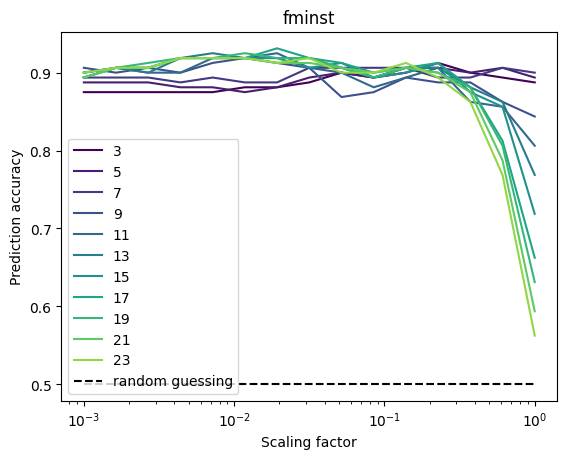

In [14]:
# plot the results
colors = create_sequential_colors(len(num_qubits)+2)

for i, accuracy_beta in enumerate(accuracy_qubit):
    plt.plot(bandwidths, accuracy_beta, color=colors[i], label=f"{num_qubits[i]}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=1e-3, xmax=1e0, linestyles='--', colors='black', label="random guessing")
plt.legend()

Now we try to showcase that the prediction accuracy is somehow related to the cost given by our `HaarEvaluator` in quask.

In [15]:
num_qubits = [3,5,7,9]
n_tr = 800
# let us sweep for different values of the bandwidth
bandwidths = np.logspace(-3,0, 15).tolist()
cost_he_qubit = []
cost_lre_qubit = []
accuracy_qubit = []
for d in num_qubits:
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d)
    cost_he_beta = []
    cost_lre_beta = []
    accuracy_beta = []
    for beta in bandwidths:
        print(f"Qubits: {d}, beta: {beta}")
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train)
        K_train_lin = linear_kernel(beta*X_train, beta*X_train)
        print("building testing kernel...")
        K_test = kernel.build_kernel(X_test, X_train)
        K_test_lin = linear_kernel(beta*X_test, beta*X_train)

        accuracy = accuracy_computation(K_train_lin, K_test_lin, y_train, y_test)
        accuracy_beta.append(accuracy)

        print("Haar evaluator...")
        he = HaarEvaluator(n_bins=40, n_samples=n_tr)
        cost_he = he.evaluate(kernel=kernel, K=K_train, X=None, y=None)
        print("Lie Rank evaluator...")
        lre = LieRankEvaluator(T=500)
        cost_lre = lre.evaluate(kernel=kernel, K=None, X=None, y=None)
        cost_he_beta.append(cost_he)
        cost_lre_beta.append(cost_lre)
    cost_he_qubit.append(cost_he_beta)
    cost_lre_qubit.append(cost_lre_beta)
    accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 800
Data loaded.
Qubits: 3, beta: 0.001
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.0016378937069540646
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.0026826957952797246
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.004393970560760791
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.0071968567300115215
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.011787686347935873
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta: 0.019306977288832496
building training kernel...
building testing kernel...
Haar evaluator...
Lie Rank evaluator...
Qubits: 3, beta:

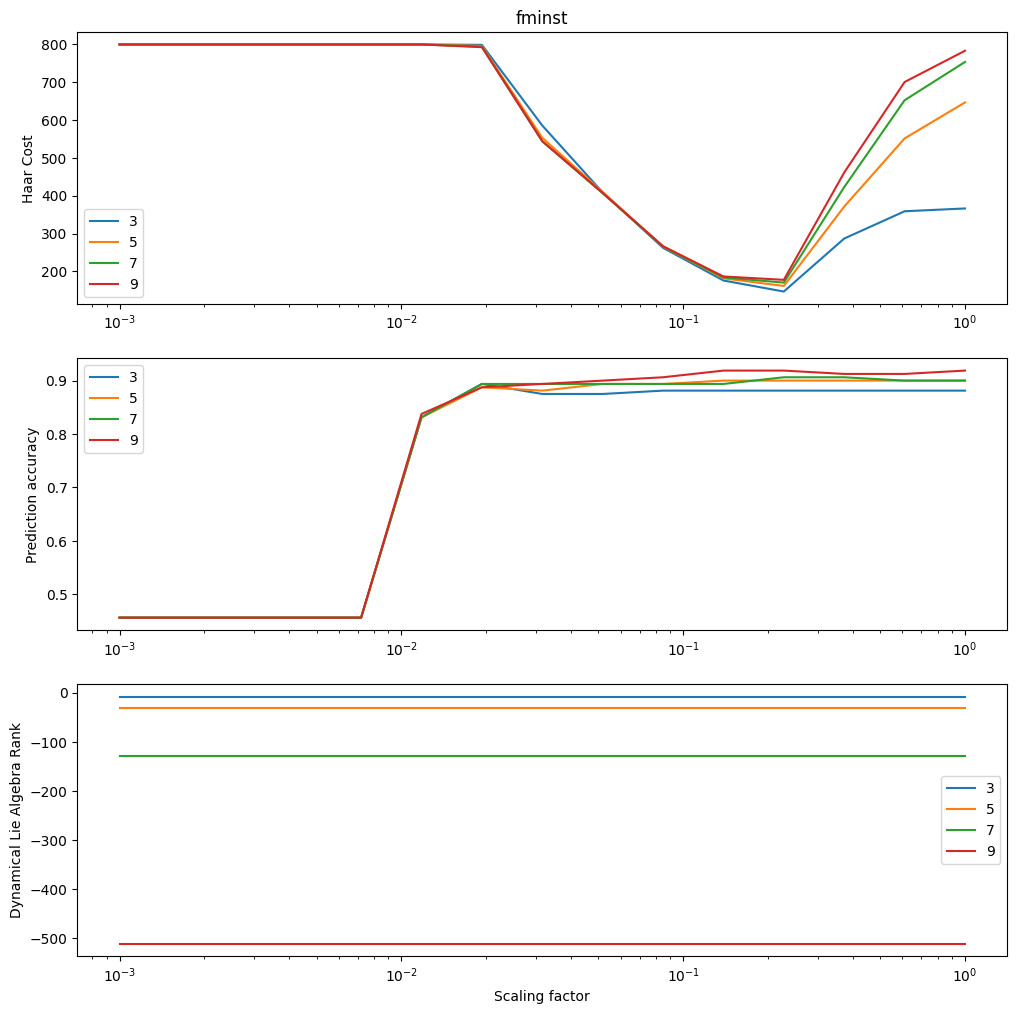

In [16]:
# plot the results
fig, axs = plt.subplots(3,1, figsize=(12,12))
for cost_he, d in zip(cost_he_qubit, num_qubits):
    axs[0].plot(bandwidths, cost_he, label=f"{d}")
axs[0].set_xscale('log')
axs[0].set_title("fminst")
axs[0].set_ylabel("Haar Cost")
axs[0].legend()
for acc, d in zip(accuracy_qubit, num_qubits):
    axs[1].plot(bandwidths, acc, label=f"{d}")
axs[1].set_xscale('log')
axs[1].set_ylabel("Prediction accuracy")
axs[1].legend()
for cost_lre, d in zip(cost_lre_qubit, num_qubits):
    axs[2].plot(bandwidths, cost_lre, label=f"{d}")
axs[2].set_xscale('log')
axs[2].set_xlabel("Scaling factor")
axs[2].set_ylabel("Dynamical Lie Algebra Rank")
axs[2].legend()

## Test with `QuASK`

In [70]:
n_tr = 50
num_qubits = [3]
accuracy_qubit = []
for d in num_qubits:
    features_quask_iqp = d + d*(d-1)/2 + 1
    features_quask_qmb = 2*d - 1
    operations_quask_iqp = d**2 + 3*d 
    operations_quask_qmb = 2*d - 1 

    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=1)
    print(f"Original shape of the train data: {X_train.shape}")
    print(f"Original shape of the test data: {X_test.shape}")

    # X_train_q = quask_features_qmb(X_train)
    # X_test_q = quask_features_qmb(X_test)
    X_train_q = X_train
    X_test_q = X_test

    accuracy_beta = []
    for beta in bandwidths:
        # X_train_q = quask_features_iqp(X_train, beta)
        # X_test_q = quask_features_iqp(X_test, beta)
        # print(f"Shape of the train data for the embedding: {X_train_q.shape}, features of quask: {features_quask_iqp}")
        # print(f"Shape of the test data for the embedding: {X_test_q.shape}, features of quask: {features_quask_iqp}")
        print(f"Qubits: {d}, beta: {beta}")
        # kernel = VaryingBandwidthQuantumKernel(N_FEATURES=features_quask_iqp, N_QUBITS=d, N_OPERATIONS=operations_quask_iqp, bandwidth=beta)
        # kernel = ManyBodyQuantumKernel(N_FEATURES=features_quask_qmb, N_QUBITS=d, N_OPERATIONS=operations_quask_qmb, bandwidth=beta)
        # kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        # print("building training kernel...")
        # K_train = kernel.build_kernel(X_train_q, X_train_q)
        K_train = rbf_kernel(X_train, X_train, gamma=beta)
        # print("building testing kernel...")
        # K_test = kernel.build_kernel(X_test_q, X_train_q)
        K_test = rbf_kernel(X_test, X_train, gamma=beta)
        # print("computing accuracy...")
        accuracy = accuracy_computation(K_train, K_test, y_train, y_test)
        print(f"Accuracy: {accuracy}")
        accuracy_beta.append(accuracy)
    accuracy_qubit.append(accuracy_beta)

    # # for beta in bandwidths:
    #     print(f"Qubits: {d}, beta: {beta}")
    #     kernel = ManyBodyAnsatz(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta, measurement=2)
    #     # kernel = VaryingBandwidthKernel(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta)
    #     print("building training kernel...")
    #     K_train = kernel.build_kernel(X_train_q, X_train_q)
    #     print("building testing kernel...")
    #     K_test = kernel.build_kernel(X_test_q, X_train_q)
    #     print("computing accuracy...")
    #     accuracy = accuracy_computation(K_train, K_test, y_train, y_test)
    #     accuracy_beta.append(accuracy)
    # accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 50
Data loaded.
Original shape of the train data: (50, 3)
Original shape of the test data: (50, 3)
Qubits: 3, beta: 0.001
Accuracy: 0.58
Qubits: 3, beta: 0.0016378937069540646
Accuracy: 0.8
Qubits: 3, beta: 0.0026826957952797246
Accuracy: 0.86
Qubits: 3, beta: 0.004393970560760791
Accuracy: 0.86
Qubits: 3, beta: 0.0071968567300115215
Accuracy: 0.86
Qubits: 3, beta: 0.011787686347935873
Accuracy: 0.86
Qubits: 3, beta: 0.019306977288832496
Accuracy: 0.88
Qubits: 3, beta: 0.03162277660168379
Accuracy: 0.92
Qubits: 3, beta: 0.0517947467923121
Accuracy: 0.92
Qubits: 3, beta: 0.08483428982440717
Accuracy: 0.92
Qubits: 3, beta: 0.13894954943731375
Accuracy: 0.92
Qubits: 3, beta: 0.22758459260747887
Accuracy: 0.9
Qubits: 3, beta: 0.3727593720314938
Accuracy: 0.86
Qubits: 3, beta: 0.6105402296585326
Accuracy: 0.76
Qubits: 3, beta: 1.0
Accuracy: 0.72


1


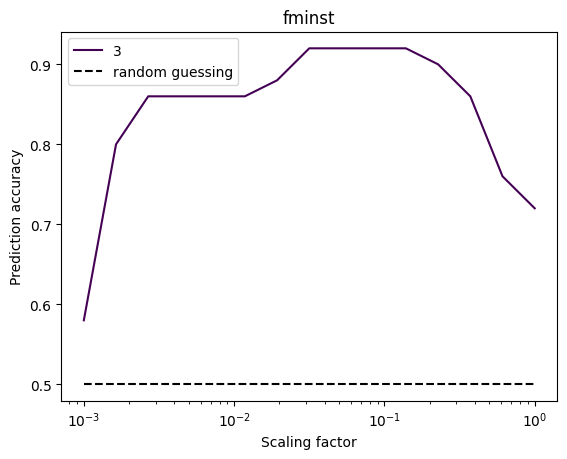

In [71]:
# plot the results
colors = create_sequential_colors(len(accuracy_qubit))

print(len(accuracy_qubit))
for i, accuracy_beta in enumerate(accuracy_qubit):
    plt.plot(bandwidths, accuracy_beta, color=colors[i], label=f"{num_qubits[i]}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=bandwidths[0], xmax=bandwidths[-1], linestyles='--', colors='black', label="random guessing")
plt.legend()

## Test with `Pennylane`


In [8]:
import pennylane as qml
from sklearn.svm import SVC
dev = qml.device('default.qubit', shots=None)

def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

def PennylaneLinearCircuit(x, bandwidth, wires):
    for j, wire in enumerate(wires):
        qml.RX(x[j % len(x)]*bandwidth, wires=[wire])

@qml.qnode(dev)
def PennylaneKernelCircuit(x1, x2, bandwidth, wires):
    exact = dev.shots.total_shots is None
    PennylaneLinearCircuit(x1, bandwidth, wires=wires)
    qml.adjoint(PennylaneLinearCircuit)(x2, bandwidth, wires=wires)
    if exact:
        return qml.state()
    else:
        return qml.probs(wires=wires)

def PennylaneLinearKernel(x1, x2, bandwidth, wires):
    return PennylaneKernelCircuit(x1, x2, bandwidth, wires)[0].real

In [121]:
qubits_list = [3]
n_tr = 50
bandwidths = np.logspace(-3,0, 15).tolist()
wires_register = {f"{i}": range(i) for i in qubits_list}
dev = qml.device('default.qubit', shots=None)

accuracy_qubit = []
for key, wire_register in wires_register.items():
    qubits = int(key)
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=qubits, n_test=1)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])
 
    accuracy_beta = []
    for beta in bandwidths:
        print(f"qubits: {qubits}, beta: {beta:.3f}")
        init_kernel = lambda x1, x2: PennylaneLinearKernel(x1, x2, beta, wire_register)
        svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train)
        accuracy_res = accuracy(svm, X_test, y_test)
        print(f"--- accuracy Pennylane: {accuracy_res:.3f}")
        accuracy_beta.append(accuracy_res)
    accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 50
Data loaded.
qubits: 3, beta: 0.001
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.002
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.003
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.004
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.007
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.012
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.019
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.032
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.052
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.085
--- accuracy Pennylane: 0.580
qubits: 3, beta: 0.139
--- accuracy Pennylane: 0.840
qubits: 3, beta: 0.228
--- accuracy Pennylane: 0.880
qubits: 3, beta: 0.373
--- accuracy Pennylane: 0.900
qubits: 3, beta: 0.611
--- accuracy Pennylane: 0.880
qubits: 3, beta: 1.000
--- accuracy Pennylane: 0.660


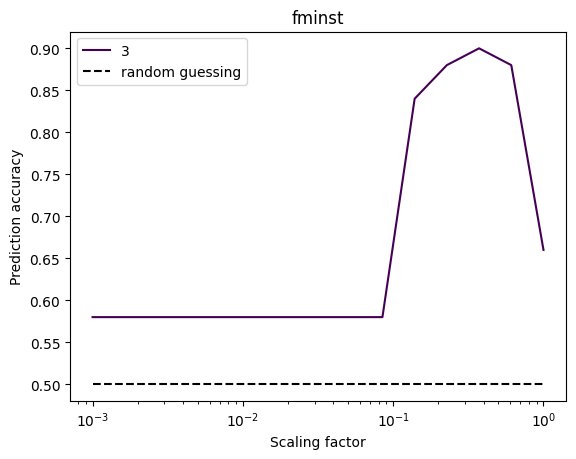

In [112]:
# plot the results
colors = create_sequential_colors(len(qubits_list)+2)

for i, accuracy_beta in enumerate(accuracy_qubit):
    plt.plot(bandwidths, accuracy_beta, color=colors[i], label=f"{qubits_list[i]}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=1e-3, xmax=1e0, linestyles='--', colors='black', label="random guessing")
plt.legend()

### Accelerate with `lightning.qubit`

Problems with Tensorflow concerning oneDNN custom operations and CPU optimizations

In [ ]:
import pennylane as qml
from sklearn.svm import SVC

qubits_list = [3,4,5]
n_tr = 50
bandwidths = np.logspace(-3,0, 15).tolist()
wires_register = {f"{i}": range(i) for i in qubits_list}

def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

accuracy_qubit = []
for key, wire_register in wires_register.items():
    qubits = int(key)
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=qubits, n_test=1)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])

    dev = qml.device('lightning.qubit', wires=qubits, batch_obs=True)
    
    def linear_circuit(x, bandwidth, wires):
        for j, wire in enumerate(wires):
            qml.RX(x[j % len(x)]*bandwidth, wires=[wire])

    @qml.qnode(dev)
    def kernel_circuit(x1, x2, bandwidth, wires):
        linear_circuit(x1, bandwidth, wires=wires)
        qml.adjoint(linear_circuit)(x2, bandwidth, wires=wires)
        return qml.probs(wires=wires)
    
    def kernel(x1, x2, bandwidth, wires):
        return kernel_circuit(x1, x2, bandwidth, wires)[0]
    
    accuracy_beta = []
    for beta in bandwidths:
        init_kernel = lambda x1, x2: kernel(x1, x2, beta, wire_register)
        svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train)
        accuracy_init = accuracy(svm, X_test, y_test)
        print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")
        accuracy_beta.append(accuracy_init)
    accuracy_qubit.append(accuracy_beta)    

## Test with `Qiskit`

In [112]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.primitives import StatevectorSampler
from sklearn.svm import SVC
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import UnitaryOverlap
from qiskit.quantum_info import Statevector

def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


def QiksitLinearCircuit(params, qubits):
    qc = QuantumCircuit(qubits)
    for j in range(qubits):
        qc.rx(params[j], j)
    return qc

def QiskitLinearKernel(x1,x2,bandwidth,qubits, exact=False):
    params = ParameterVector('x', 2*qubits)
    qc = QiksitLinearCircuit(params, qubits=qubits)
    unitary1 = qc.assign_parameters(x1*bandwidth) # inplace=True
    unitary2 = qc.assign_parameters(x2*bandwidth) # inplace=True
    overlap_circ = UnitaryOverlap(unitary1, unitary2)
    if exact:
        return overlap_circ
    else:
        overlap_circ.measure_all()
        return overlap_circ

def QiskitKernelEstimation(ker_type: str, sampler, num_shots, X_train, X_test=None, bandwidth=1):
    if ker_type == "tr":
        K = QiskitTrainingKernel(sampler, X_train, bandwidth, num_shots)
    elif ker_type == 'te':
        K = QiskitTestingKernel(sampler, X_train, X_test, bandwidth, num_shots)
    return K

def QiskitTrainingKernel(sampler, X_train, bandwidth, num_shots=None):
    N = X_train.shape[0]
    kernel_matrix = np.full((N, N), np.nan)
    exact = num_shots is None
    for i in range(kernel_matrix.shape[0]):
        for j in range(i,kernel_matrix.shape[1]):
            if i == j:
                kernel_matrix[i,j] = 1
            else:
                kernel_elem = QiskitLinearKernel(X_train[i],X_train[j], bandwidth, qubits, exact)
                kernel_matrix[i,j] = estimate_element(kernel_elem, sampler, num_shots)
                kernel_matrix[j,i] = kernel_matrix[i,j]
    return kernel_matrix

def QiskitTestingKernel(sampler, X_train, X_test, bandwidth, num_shots):
    N_tr = X_train.shape[0]
    N_te = X_test.shape[0]
    kernel_matrix = np.full((N_te, N_tr), np.nan)
    exact = num_shots is None
    for i in range(kernel_matrix.shape[0]):
        for j in range(kernel_matrix.shape[1]):
            kernel_elem = QiskitLinearKernel(X_test[i],X_train[j], bandwidth, qubits, exact)
            kernel_matrix[i,j] = estimate_element(kernel_elem, sampler, num_shots)
    return kernel_matrix

def estimate_element(overlap_circ, sampler, num_shots):
    if num_shots == None:
        res = Statevector.from_instruction(overlap_circ).data[0].real
    else:
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )
        dist = QuasiDistribution(
            {meas: count / num_shots for meas, count in counts.items()}, shots=num_shots
        )
        res = dist.get(0, 0.0)
    return res

In [114]:
qubits_list = [3]
n_tr = 50
bandwidths = np.logspace(-3,0, 15).tolist()
num_shots = None # if using statevector to find exact amplitudes
# num_shots = 1024 # if using sampler or estimator with simulator or real hardware backends
sampler = StatevectorSampler()

accuracy_qubit = []
for qubits in qubits_list:
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=qubits, n_test=1)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])
 
    accuracy_beta = []
    for beta in bandwidths:
        print(f"qubits: {qubits}, beta: {beta:.3f}")
        K_train = QiskitKernelEstimation(ker_type='tr', sampler=sampler, num_shots=None, X_train=X_train, bandwidth=beta)
        K_test = QiskitKernelEstimation(ker_type='te', sampler=sampler, num_shots=None, X_train=X_train, X_test=X_test, bandwidth=beta)
        svm = SVC(kernel='precomputed').fit(K_train, y_train)
        accuracy_res = accuracy(svm, K_test, y_test)
        print(f"--- accuracy Qiskit: {accuracy_res:.3f}")
        accuracy_beta.append(accuracy_res)
    accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 50
Data loaded.
qubits: 3, beta: 0.001
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.002
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.003
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.004
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.007
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.012
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.019
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.032
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.052
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.085
--- accuracy Qiskit: 0.580
qubits: 3, beta: 0.139
--- accuracy Qiskit: 0.840
qubits: 3, beta: 0.228
--- accuracy Qiskit: 0.880
qubits: 3, beta: 0.373
--- accuracy Qiskit: 0.900
qubits: 3, beta: 0.611
--- accuracy Qiskit: 0.880
qubits: 3, beta: 1.000
--- accuracy Qiskit: 0.660


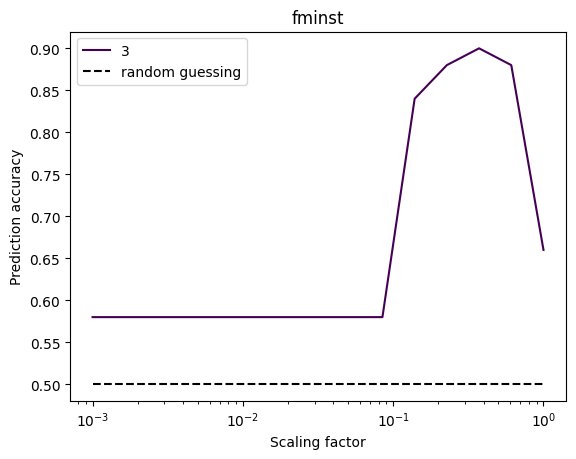

In [115]:
# plot the results
colors = create_sequential_colors(len(qubits_list)+2)

for i, accuracy_beta in enumerate(accuracy_qubit):
    plt.plot(bandwidths, accuracy_beta, color=colors[i], label=f"{qubits_list[i]}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=1e-3, xmax=1e0, linestyles='--', colors='black', label="random guessing")
plt.legend()

New datapoint dimension: 3
Number of datapoints 50
Data loaded.


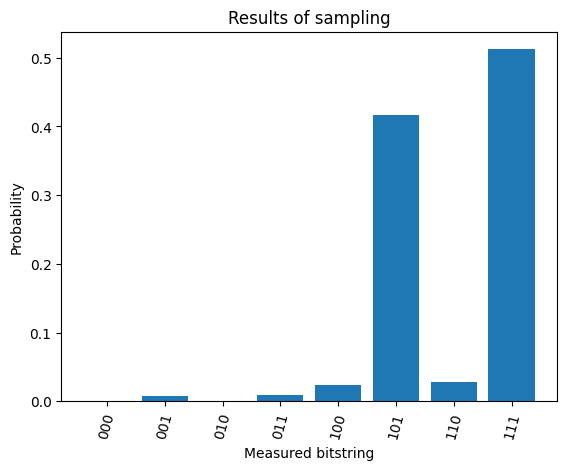

Fidelity: 0.0004


In [38]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import UnitaryOverlap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService 
from qiskit_ibm_runtime import Options, Session, Sampler
from qiskit_aer import AerSimulator

# Remember to insert your token in the QiskitRuntimeService constructor
overlap_circ = QuantumCircuit(2)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits
)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

overlap_ibm = pm.run(overlap_circ)
overlap_ibm.draw("mpl", scale=0.6, idle_wires=False, fold=-1, style="iqp")

# Evaluate the problem using a QPU via Qiskit IBM Runtime
backend = AerSimulator()
with Session(service=service, backend=backend) as session:
    sampler = Sampler(
        options=Options(
            execution={"shots": num_shots}, transpilation={"skip_transpilation": True}
        )
    )
    dist = sampler.run(overlap_ibm).result().quasi_dists[0]


## Compare shots `Pennylane` $vs$ `Qiskit`

In [92]:
wire_register = list(range(3))
accuracy_beta_pennylane = []
accuracy_beta_qiskit = []
for beta in bandwidths:
    print(f"qubits: {qubits}, beta: {beta:.3f}")
    init_kernel = lambda x1, x2: PennylaneLinearKernel(x1, x2, beta, wire_register)
    svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train)
    accuracy_res = accuracy(svm, X_test, y_test)
    print(f"--- accuracy pennylane: {accuracy_res:.3f}")
    accuracy_beta_pennylane.append(accuracy_res)

    K_train = QiskitKernelEstimation(ker_type='tr', sampler=sampler, num_shots=None, X_train=X_train, bandwidth=beta)
    K_test = QiskitKernelEstimation(ker_type='te', sampler=sampler, num_shots=None, X_train=X_train, X_test=X_test, bandwidth=beta)
    svm = SVC(kernel='precomputed').fit(K_train, y_train)
    accuracy_res = accuracy(svm, K_test, y_test)
    print(f"--- accuracy qiskit: {accuracy_res:.3f}")
    accuracy_beta_qiskit.append(accuracy_res)

qubits: 3, beta: 0.001
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.0016378937069540646
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.0026826957952797246
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.004393970560760791
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.0071968567300115215
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.011787686347935873
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.019306977288832496
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.03162277660168379
--- accuracy pennylane: 0.5800000000000001
--- accuracy qiskit: 0.5800000000000001
qubits: 3, beta: 0.0517947467923121
--- accur

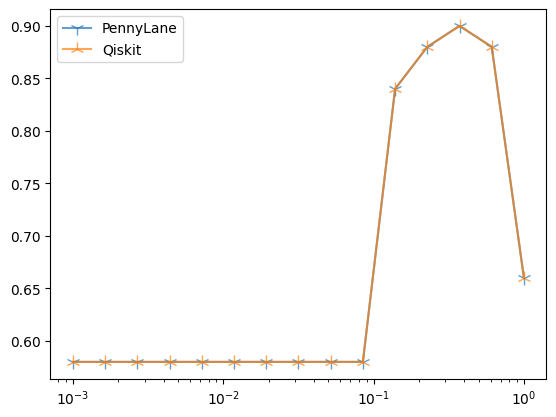

In [118]:
plt.plot(bandwidths, accuracy_beta_pennylane, marker='1', markersize=10, alpha=0.7, label='PennyLane')
plt.plot(bandwidths, accuracy_beta_qiskit, marker='2', markersize=10, alpha=0.7, label='Qiskit')
plt.xscale('log')
plt.legend()

In [36]:
qubits = 3
wire_register = list(range(qubits))
n_tr = 50
shots_list = [1e1,1e2,1e3]
bandwidths = np.logspace(-3,0, 15).tolist()
X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=qubits, n_test=1)
y_train = np.array([1 if y == True else -1 for y in y_train])
y_test = np.array([1 if y == True else -1 for y in y_test])

# Pennylane Kernel Estimation
import pennylane as qml
dev = qml.device('default.qubit', shots=None)

def PennylaneLinearCircuit(x, bandwidth, wires):
    for j, wire in enumerate(wires):
        qml.RX(x[j % len(x)]*bandwidth, wires=[wire])

@qml.qnode(dev)
def PennylaneKernelCircuit(x1, x2, bandwidth, wires):
    exact = dev.shots.total_shots is None
    PennylaneLinearCircuit(x1, bandwidth, wires=wires)
    qml.adjoint(PennylaneLinearCircuit)(x2, bandwidth, wires=wires)
    if exact:
        return qml.state()
    else:
        return qml.probs(wires=wires)

def PennylaneLinearKernel(x1, x2, bandwidth, wires):
    return PennylaneKernelCircuit(x1, x2, bandwidth, wires)[0].real

init_kernel = lambda x1, x2: PennylaneLinearKernel(x1, x2, bandwidths[-3], wire_register)
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train)
accuracy_res = accuracy(svm, X_test, y_test)
exact_pennylane = accuracy_res
print(f"The accuracy of the pennylane kernel is {accuracy_res:.3f}")

sampler = StatevectorSampler()

K_train = QiskitKernelEstimation(ker_type='tr', sampler=sampler, X_train=X_train, bandwidth=bandwidths[-3], num_shots=None)
K_test = QiskitKernelEstimation(ker_type='te', sampler=sampler, X_train=X_train, X_test=X_test, bandwidth=bandwidths[-3], num_shots=None)
svm = SVC(kernel='precomputed').fit(K_train, y_train)
accuracy_res = accuracy(svm, K_test, y_test)
exact_qiskit = accuracy_res
print(f"The accuracy of the qiskit kernel is {accuracy_res:.3f}")

# Number of runs to estimate the standard deviation
num_runs = 10

# Initialize lists to store accuracies for multiple runs
acc_shots_qis = []
acc_shots_penn = []

# Iterate over the number of shots
for num_shots in shots_list:
    num_shots = int(num_shots)
    print(f"Shots: {num_shots}")
    
    # Initialize lists for accuracies of current shot count
    qis_accuracies = []
    # penn_accuracies = []
    # # Pennylane Kernel Estimation
    # dev = qml.device('default.qubit', shots=num_shots)
    
    # def PennylaneLinearCircuit(x, bandwidth, wires):
    #     for j, wire in enumerate(wires):
    #         qml.RX(x[j % len(x)]*bandwidth, wires=[wire])

    # @qml.qnode(dev)
    # def PennylaneKernelCircuit(x1, x2, bandwidth, wires):
    #     exact = dev.shots.total_shots is None
    #     PennylaneLinearCircuit(x1, bandwidth, wires=wires)
    #     qml.adjoint(PennylaneLinearCircuit)(x2, bandwidth, wires=wires)
    #     if exact:
    #         return qml.state()
    #     else:
    #         return qml.probs(wires=wires)

    # def PennylaneLinearKernel(x1, x2, bandwidth, wires):
    #     return PennylaneKernelCircuit(x1, x2, bandwidth, wires)[0].real
    
    sampler = StatevectorSampler()

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")

        # init_kernel = lambda x1, x2: PennylaneLinearKernel(x1, x2, bandwidths[-3], wire_register)
        # svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train)
        # accuracy_res = accuracy(svm, X_test, y_test)
        # penn_accuracies.append(accuracy_res)

        # Qiskit Kernel Estimation
        K_train = QiskitKernelEstimation(ker_type='tr', sampler=sampler, X_train=X_train, bandwidth=bandwidths[-3], num_shots=num_shots)
        K_test = QiskitKernelEstimation(ker_type='te', sampler=sampler, X_train=X_train, X_test=X_test, bandwidth=bandwidths[-3], num_shots=num_shots)
        svm = SVC(kernel='precomputed').fit(K_train, y_train)
        accuracy_res = accuracy(svm, K_test, y_test)
        qis_accuracies.append(accuracy_res)

    # Append mean accuracy and standard deviation for Qiskit
    acc_shots_qis.append({
        'shots': num_shots,
        'mean': np.mean(qis_accuracies),
        'std': np.std(qis_accuracies)
    })

    # Append mean accuracy and standard deviation for PennyLane
    # acc_shots_penn.append({
    #     'shots': num_shots,
    #     'mean': np.mean(penn_accuracies),
    #     'std': np.std(penn_accuracies)
    # })

    # Print mean and standard deviation for current number of shots
    # print(f"Pennylane Kernel (shots={num_shots}): Mean accuracy = {np.mean(penn_accuracies):.3f}, Std = {np.std(penn_accuracies):.3f}")
    print(f"Qiskit Kernel (shots={num_shots}): Mean accuracy = {np.mean(qis_accuracies):.3f}, Std = {np.std(qis_accuracies):.3f}")

New datapoint dimension: 3
Number of datapoints 50
Data loaded.
The accuracy of the pennylane kernel is 0.900
The accuracy of the qiskit kernel is 0.900
Shots: 10
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Qiskit Kernel (shots=10): Mean accuracy = 0.850, Std = 0.034
Shots: 100
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Qiskit Kernel (shots=100): Mean accuracy = 0.882, Std = 0.021
Shots: 1000
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Qiskit Kernel (shots=1000): Mean accuracy = 0.896, Std = 0.022


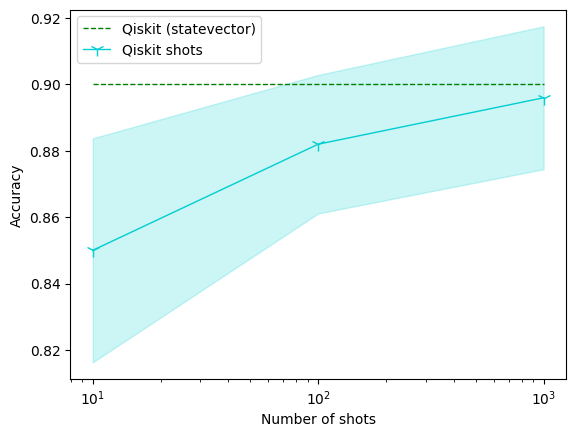

In [37]:
# Plot the exact statevector results as horizontal lines
# plt.hlines(y=exact_pennylane, xmin=shots_list[0], xmax=shots_list[-1], linestyle='--', color='r', linewidth=1, label='Pennylane (statevector)')
plt.hlines(y=exact_qiskit, xmin=shots_list[0], xmax=shots_list[-1], linestyle='--', color='g', linewidth=1, label='Qiskit (statevector)')

# Plot the Qiskit results with error bars (mean accuracy and standard deviation)
qis_means = [entry['mean'] for entry in acc_shots_qis]
qis_stds = [entry['std'] for entry in acc_shots_qis]
plt.plot(shots_list, qis_means, marker='1', markersize=10, linewidth=1, label='Qiskit shots', color='darkturquoise')
plt.fill_between(shots_list, 
                 [m - s for m, s in zip(qis_means, qis_stds)], 
                 [m + s for m, s in zip(qis_means, qis_stds)], 
                 color='darkturquoise', alpha=0.2)
# plt.errorbar(shots_list, qis_means, yerr=qis_stds, fmt='-o', markersize=5, linewidth=1, label='Qiskit shots', capsize=3)

# # Plot the PennyLane results with error bars (mean accuracy and standard deviation)
# penn_means = [entry['mean'] for entry in acc_shots_penn]
# penn_stds = [entry['std'] for entry in acc_shots_penn]
# plt.plot(shots_list, penn_means, marker='1', markersize=10, linewidth=1, label='Pennylane shots', color='b')
# plt.fill_between(shots_list, 
#                  [m - s for m, s in zip(penn_means, penn_stds)], 
#                  [m + s for m, s in zip(penn_means, penn_stds)], 
#                  color='b', alpha=0.2)

# Set logarithmic scale for the x-axis (number of shots)
plt.xscale('log')

# Labels and legend
plt.xlabel("Number of shots")
plt.ylabel("Accuracy")
plt.legend()

# Show the plot
plt.show()


In [17]:
accuracy_beta = []
# bandwidths = np.logspace(-3,0,15)
for beta in bandwidths:
    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=qubits, n_test=1);
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])
    X_train = np.array([x*beta for x in X_train])
    X_test = np.array([x*beta for x in X_test])
    svm = SVC(kernel='linear').fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    res = accuracy_score(y_test, y_pred)
    accuracy_beta.append(res)

New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.
New datapoint dimension: 3
Number of datapoints 50
Data loaded.


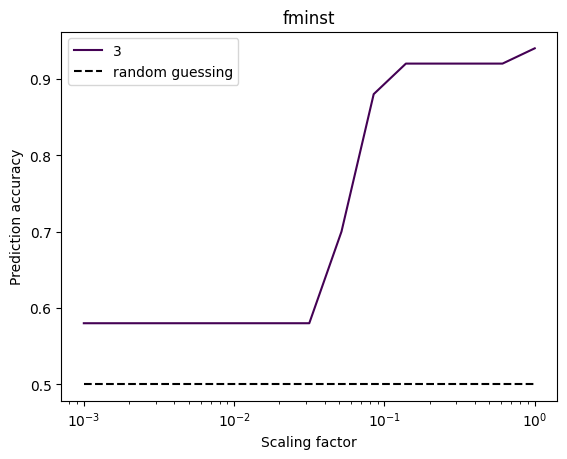

In [21]:
# plot the results
colors = create_sequential_colors(qubits)

plt.plot(bandwidths, accuracy_beta, color=colors[0], label=f"{qubits}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=bandwidths[0], xmax=bandwidths[-1], linestyles='--', colors='black', label="random guessing")
plt.legend()

## `Qiskit` with `Quask`

In [6]:
from quask.core_implementation import QiskitKernel
def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, platform="infty_shots")

KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')
print(KernelFactory._KernelFactory__implementations)
print(KernelFactory._KernelFactory__current_implementation)

{'qiskit_noiseless': <function create_qiskit_noiseless at 0x0000011B73142A20>}
qiskit_noiseless


### Example of overlap circuit

New datapoint dimension: 4
Number of datapoints 10
Data loaded.
As expected, the overlaps of the data with themselves are: [0.9999999999999997, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0000000000000002, 1.0, 0.9999999999999998, 1.0, 1.0000000000000002, 1.0]


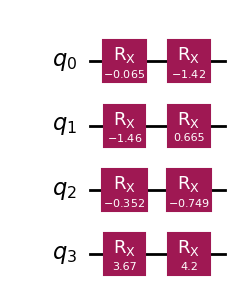

In [125]:
d = 4
n_tr = 10
X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=1)
kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=1)
kernel.platform = "infty_shots"
print(f"As expected, the overlaps of the data with themselves are: {[kernel.kappa(X_train[i],X_train[i]) for i in range(X_train.shape[0])]}")
qc1 = kernel.get_qiskit_ansatz().assign_parameters(X_train[5])
qc2 = kernel.get_qiskit_ansatz().assign_parameters(X_train[9])
qc = UnitaryOverlap(qc1,qc2)
qc.decompose(reps=1).draw('mpl')

### Quantum Kernel Estimation in a classification problem

In [152]:
n_tr = 30
num_qubits = [3]
bandwidths = np.logspace(-3,1,20)
accuracy_qubit = []
for d in num_qubits:
    # features_quask_iqp = d + d*(d-1)/2 + 1
    # features_quask_qmb = 2*d - 1
    # operations_quask_iqp = d**2 + 3*d 
    # operations_quask_qmb = 2*d - 1 

    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=0.3)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])

    accuracy_beta = []
    for beta in bandwidths:
        print(f"Qubits: {d}, beta: {beta}")
        # X_train_q = quask_features_iqp(X_train, beta)
        # X_test_q = quask_features_iqp(X_test, beta)
        # kernel = ManyBodyAnsatz(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta, measurement=2)
        # kernel = VaryingBandwidthKernel(N_FEATURES=features_quask, N_QUBITS=d, N_OPERATIONS=operations_quask, bandwidth=beta)
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train, matrix="train")
        print("building testing kernel...")
        K_test = kernel.build_kernel(X_test, X_train, matrix="test")
        print("computing accuracy...")
        svm = SVC(kernel='precomputed').fit(K_train, y_train)
        accuracy_res = accuracy(svm, K_test, y_test)
        accuracy_beta.append(accuracy_res)
    accuracy_qubit.append(accuracy_beta)

New datapoint dimension: 3
Number of datapoints 30
Data loaded.
Qubits: 3, beta: 0.001
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.001623776739188721
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0026366508987303583
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.004281332398719396
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0069519279617756054
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.011288378916846888
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.018329807108324356
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.029763514416313176
building training kernel...
building testing kernel...
computing accuracy...
Qubits: 3, beta: 0.0483293023

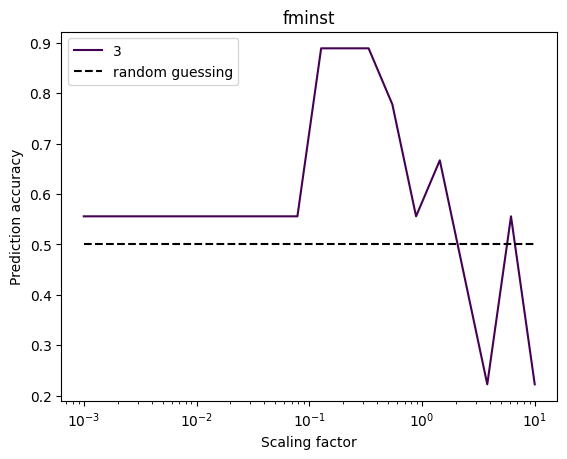

In [153]:
# plot the results
colors = create_sequential_colors(num_qubits[0])

plt.plot(bandwidths, accuracy_beta, color=colors[0], label=f"{num_qubits[0]}")
plt.xscale('log')
plt.title("fminst")
plt.xlabel("Scaling factor")
plt.ylabel("Prediction accuracy")
plt.hlines(y=0.5, xmin=bandwidths[0], xmax=bandwidths[-1], linestyles='--', colors='black', label="random guessing")
plt.legend()

### Inifite $vs$ Finite shots kernels

In [154]:
from quask.core_implementation import QiskitKernel
def create_qiskit_kernel(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, platform="finite_shots")

# KernelFactory.add_implementation('qiskit_shots', create_qiskit_kernel)
KernelFactory.set_current_implementation('qiskit_shots')
print(KernelFactory._KernelFactory__implementations)

{'qiskit_noiseless': <function create_qiskit_noiseless at 0x0000011B73142A20>, 'qiskit_shots': <function create_qiskit_finite_shots at 0x0000011B8C0B6A20>, 'qiskit_kernel': <function create_qiskit_kernel at 0x0000011B8C96E5C0>}


In [155]:
# Number of runs to estimate the standard deviation
num_runs = 10
shots_list = [10,100,1000]
# Initialize lists to store accuracies for multiple runs
acc_shots_qis = []
beta_best = bandwidths[np.argmax(accuracy_beta)]

# Iterate over the number of shots
for n_shots in shots_list:
    n_shots = int(n_shots)
    print(f"Shots: {n_shots}")
    
    # Initialize lists for accuracies of current shot count
    qis_accuracies = []
    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")

        # Qiskit Kernel Estimation
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta_best)
        kernel.n_shots = n_shots
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train, matrix="train")
        print("building testing kernel...")
        K_test = kernel.build_kernel(X_test, X_train, matrix="test")
        print("computing accuracy...")
        svm = SVC(kernel='precomputed').fit(K_train, y_train)
        accuracy_res = accuracy(svm, K_test, y_test)
        qis_accuracies.append(accuracy_res)

    # Append mean accuracy and standard deviation for Qiskit
    acc_shots_qis.append({
        'shots': n_shots,
        'mean': np.mean(qis_accuracies),
        'std': np.std(qis_accuracies)
    })

    # Print mean and standard deviation for current number of shots
    # print(f"Pennylane Kernel (shots={n_shots}): Mean accuracy = {np.mean(penn_accuracies):.3f}, Std = {np.std(penn_accuracies):.3f}")
    print(f"Qiskit Kernel (shots={n_shots}): Mean accuracy = {np.mean(qis_accuracies):.3f}, Std = {np.std(qis_accuracies):.3f}")

Shots: 10
Run 1/10
building training kernel...
building testing kernel...
computing accuracy...
Run 2/10
building training kernel...
building testing kernel...
computing accuracy...
Run 3/10
building training kernel...
building testing kernel...
computing accuracy...
Run 4/10
building training kernel...
building testing kernel...
computing accuracy...
Run 5/10
building training kernel...
building testing kernel...
computing accuracy...
Run 6/10
building training kernel...
building testing kernel...
computing accuracy...
Run 7/10
building training kernel...
building testing kernel...
computing accuracy...
Run 8/10
building training kernel...
building testing kernel...
computing accuracy...
Run 9/10
building training kernel...
building testing kernel...
computing accuracy...
Run 10/10
building training kernel...
building testing kernel...
computing accuracy...
Qiskit Kernel (shots=10): Mean accuracy = 0.778, Std = 0.086
Shots: 100
Run 1/10
building training kernel...
building testing ker

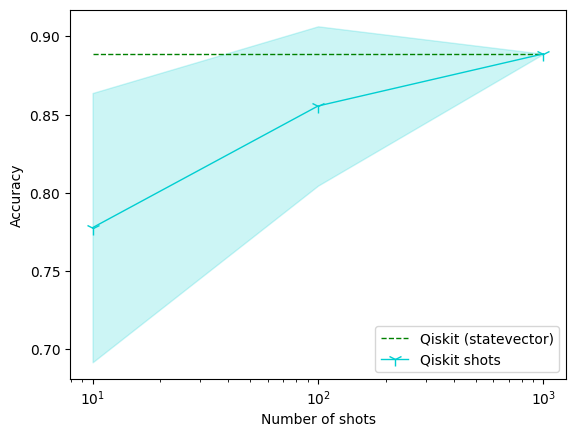

In [156]:
exact_qiskit = np.max(accuracy_beta)
# Plot the exact statevector results as horizontal lines
plt.hlines(y=exact_qiskit, xmin=shots_list[0], xmax=shots_list[-1], linestyle='--', color='g', linewidth=1, label='Qiskit (statevector)')

# Plot the Qiskit results with error bars (mean accuracy and standard deviation)
qis_means = [entry['mean'] for entry in acc_shots_qis]
qis_stds = [entry['std'] for entry in acc_shots_qis]
plt.plot(shots_list, qis_means, marker='1', markersize=10, linewidth=1, label='Qiskit shots', color='darkturquoise')
plt.fill_between(shots_list, 
                 [m - s for m, s in zip(qis_means, qis_stds)], 
                 [m + s for m, s in zip(qis_means, qis_stds)], 
                 color='darkturquoise', alpha=0.2)

# Set logarithmic scale for the x-axis (number of shots)
plt.xscale('log')

# Labels and legend
plt.xlabel("Number of shots")
plt.ylabel("Accuracy")
plt.legend()

# Show the plot
plt.show()

## ``Haar evaluator`` with `Quask`

In [ ]:
KernelFactory.set_current_implementation('qiskit_noiseless')
for d in num_qubits:

    X_train, X_test, y_train, y_test = create_dataset(N_TRAIN=n_tr, features_DIM=d, n_test=0.3)
    y_train = np.array([1 if y == True else -1 for y in y_train])
    y_test = np.array([1 if y == True else -1 for y in y_test])

    cost_he_beta = []
    cost_lre_beta = []
    for beta in bandwidths:
        print(f"Qubits: {d}, beta: {beta}")
        kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=beta)
        print("building training kernel...")
        K_train = kernel.build_kernel(X_train, X_train, matrix="train")
        print("Haar evaluator...")
        he = HaarEvaluator(n_bins=40, n_samples=n_tr)
        cost_he = he.evaluate(kernel=kernel, K=K_train, X=None, y=None)
        print(f"--- {cost_he}")
        print("Lie Rank evaluator...")
        lre = LieRankEvaluator(T=500)
        cost_lre = lre.evaluate(kernel=kernel, K=None, X=None, y=None)
        print(f"--- {cost_lre}")
        cost_he_beta.append(cost_he)
        cost_lre_beta.append(-cost_lre)

New datapoint dimension: 3
Number of datapoints 30
Data loaded.
Qubits: 3, beta: 0.001
building training kernel...
Haar evaluator...
--- 30.001566997971892
Lie Rank evaluator...
--- -8
Qubits: 3, beta: 0.001623776739188721
building training kernel...
Haar evaluator...
--- 30.001566997971892
Lie Rank evaluator...
--- -8
Qubits: 3, beta: 0.0026366508987303583
building training kernel...
Haar evaluator...
--- 30.001566997971892
Lie Rank evaluator...
--- -8
Qubits: 3, beta: 0.004281332398719396
building training kernel...
Haar evaluator...
--- 30.001566997971892
Lie Rank evaluator...
--- -8
Qubits: 3, beta: 0.0069519279617756054
building training kernel...
Haar evaluator...
--- 30.001566997971892
Lie Rank evaluator...
--- -8
Qubits: 3, beta: 0.011288378916846888
building training kernel...
Haar evaluator...
--- 30.001566997971892
Lie Rank evaluator...
--- -8
Qubits: 3, beta: 0.018329807108324356
building training kernel...


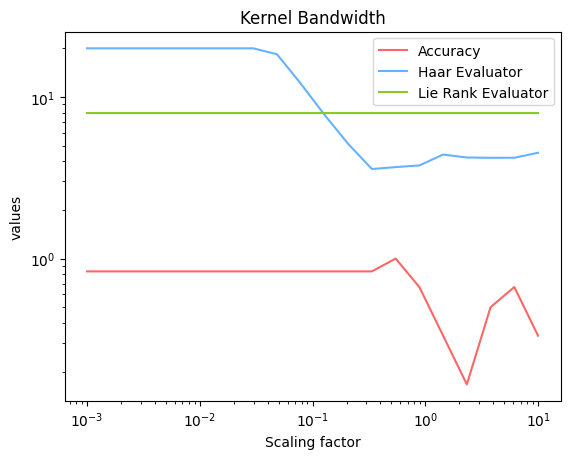

In [151]:
# plot the results
colors = ['#FF6666', '#66B2FF', '#8AC926']

plt.plot(bandwidths, accuracy_beta, color=colors[0], label=f"Accuracy")
plt.plot(bandwidths, cost_he_beta, color=colors[1], label=f"Haar Evaluator")
plt.plot(bandwidths, cost_lre_beta, color=colors[2], label=f"Lie Rank Evaluator")
plt.xscale('log')
plt.yscale('log')
plt.title("Kernel Bandwidth accuracy $vs$ Haar cost")
plt.xlabel("Scaling factor")
plt.ylabel("values")
# plt.hlines(y=0.5, xmin=bandwidths[0], xmax=bandwidths[-1], linestyles='--', colors='black', label="random guessing")
plt.legend()

## IBM Quantum Hardware with `Quask`

For the sake of simplicity we perform a small example where we use one of the IBM QPUs to estimate an entry of our Quantum Kernel matrix. Quask creates kernels independently from the backend as abstract objects. To use `qiskit` we specify the argument `platform`.

In [38]:
from quask.core_implementation import QiskitKernel
def create_qiskit_kernel(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, platform="ibm_quantum")

KernelFactory.add_implementation('qiskit_kernel_qpu', create_qiskit_kernel)
KernelFactory.set_current_implementation('qiskit_kernel_qpu')
print(KernelFactory._KernelFactory__implementations)

{'qiskit_noiseless': <function create_qiskit_noiseless at 0x0000011B73142A20>, 'qiskit_shots': <function create_qiskit_finite_shots at 0x0000011B8C0B6A20>, 'qiskit_kernel': <function create_qiskit_kernel at 0x0000011B8C96E5C0>}


In [60]:
channel = "ibm_quantum"
platform = channel

# do not define any device for 'least_busy()' option
## Open Plan devices
device = "ibm_kyiv"
# device = "ibm_sherbrooke"
# device = "ibm_brisbane"

## Premium Plan devices
# device = "ibm_torino"
# device = "ibm_fez"


ibm_token = "" # insert here your ibm token
# group_instance = "ibm-q-ikerbasque/generic/generic-project" # insert here your ibm group instance relative to your project
group_instance = "ibm-q/open/main" # insert here your free access ibm instance

In [61]:
# backend options
n_shots = 10000
dd_seq = "XY4"
tw_g = True
tw_m = True

sampler_options = {
    "default_shots": n_shots,
    "dynamical_decoupling": {
        "enable": bool(dd_seq),
        "sequence_type": dd_seq
    },
    "twirling": {
        "enable_gates": tw_g,
        "enable_measure": tw_m,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

# transpilation options
layout = None
optimization_level = 2

In [62]:
# create the linear kernel for backend support and initialize it
d = 3 
kernel = LinearQuantumKernel(N_FEATURES=d, N_QUBITS=d, N_OPERATIONS=d, bandwidth=bandwidths[-3])
kernel.get_backend(channel, ibm_token, group_instance, device)
kernel.platform = platform
kernel.n_shots = n_shots
kernel.options = sampler_options
kernel.optimization_level = optimization_level
kernel.layout = layout

Send job to the QPU selected

In [66]:
# the kernel in fully initialized and we can execute to the hardware
kernel_entry_job = kernel.build_kernel(X_train[15], X_train[29])

Job sent to hardware. Job ID: cwgfd1w9r49g00860h70


We can plot the sampling of the different configurations 

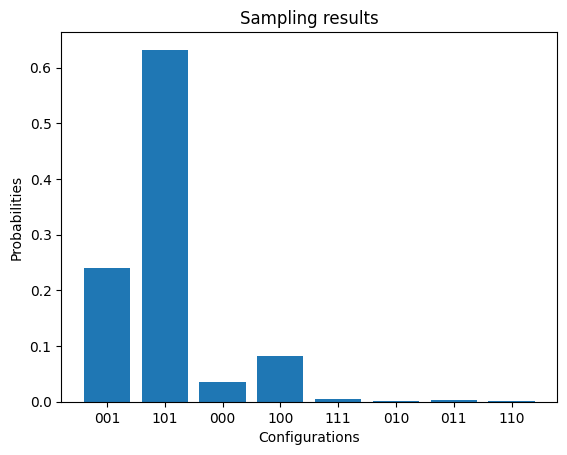

In [81]:
counts = kernel_entry_job.result()[0].data.meas.get_counts()
keys = [key for key, value in counts.items()]
values = [value/n_shots for key, value in counts.items()]

container = plt.bar(keys, values, width=0.8)

plt.title('Sampling results')
plt.xlabel('Configurations')
plt.ylabel('Probabilities')

plt.show()

In [77]:
# get the kernel entry after the job is finished
kernel_entry = kernel.get_job_results(kernel_entry_job)
kernel_entry

0.0363

We computed the overlap between two different datapoints on the Quantum Hardware